In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils

import os
from pprint import pprint
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import pandas as pd

# import hydromt and setup logging
import hydromt
from hydromt.log import setuplog

# set working directory

path = r"C:\Users\sungg1095\Documents\GitHub\baltic_sfincs"

In [2]:
## DEFINE MODEL AS sf BY GIVING DIRECTORY OF DATA CATALOG AND MODEL OUTPUT DIRECTORY
sf = SfincsModel(data_libs=[f"{path}/baltic_data/Baltic.yml"], root=f"{path}//output", mode="w+")                  

Model dir already exists and files might be overwritten: C:\Users\sungg1095\Documents\GitHub\baltic_sfincs\output\gis.


In [3]:
##MAKE MODEL GRID

sf.setup_grid_from_region(
     region = {'geom': 'baltic_data/boundary/model_domain_32632_small.geojson'},
     res= 50,
     rotated=False,
     crs=32632
 )
# the input file is automatically updated. Uncomment to displayed below:
print(sf.config)

{'mmax': 3035, 'nmax': 2585, 'dx': 50, 'dy': 50, 'x0': 514904.0, 'y0': 5953021.0, 'rotation': 0, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 99999.0, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 2, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 32632}


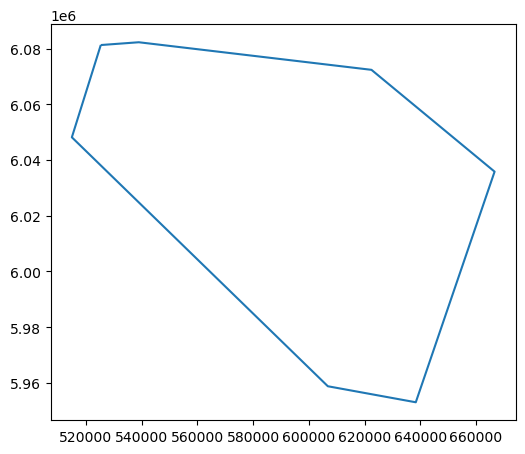

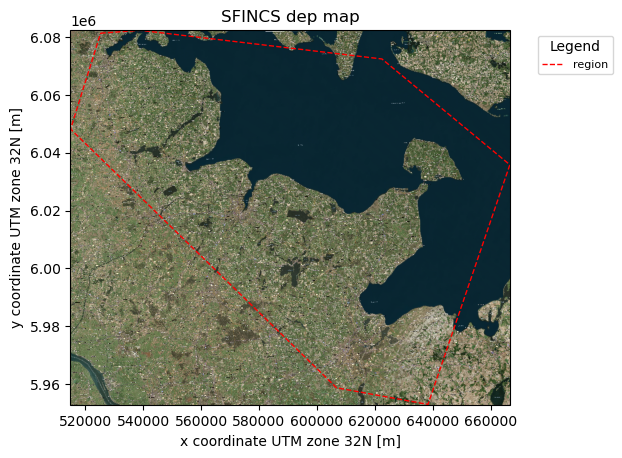

In [4]:
##### PLOT GRID OUTLINE #####
sf.region.boundary.plot(figsize=(6,6))
##'sat' = satellite 
_ = sf.plot_basemap(plot_region=True, bmap="sat", zoomlevel=12)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


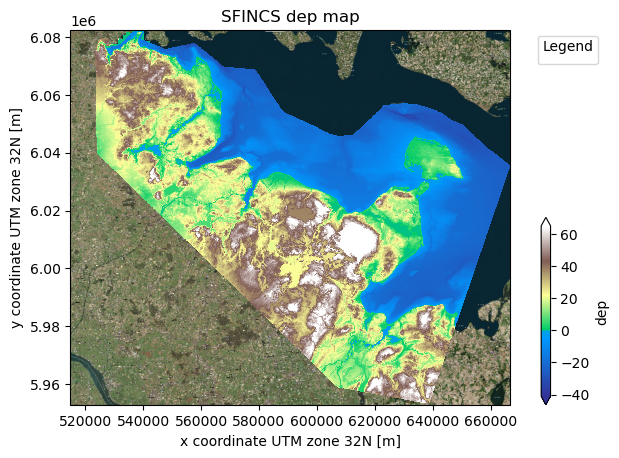

In [5]:
#### SETUP ELEVATION AND BATHY IN MODEL DOMAIN ####
# My DEM represents bathymetry and elevation
# create variable datasets_dep by assigning my DEM that is stored in the data catalogue

datasets_dep = [{"elevtn": "bath_ele"}, {"elevtn": "bath_ele"}]

# Add depth information stored in variable datasets_dep to the modelgrid
dep = sf.setup_dep(datasets_dep=datasets_dep)

# Make a plot of the merged topobathy
_ = sf.plot_basemap(variable="dep", bmap="sat", zoomlevel=12)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


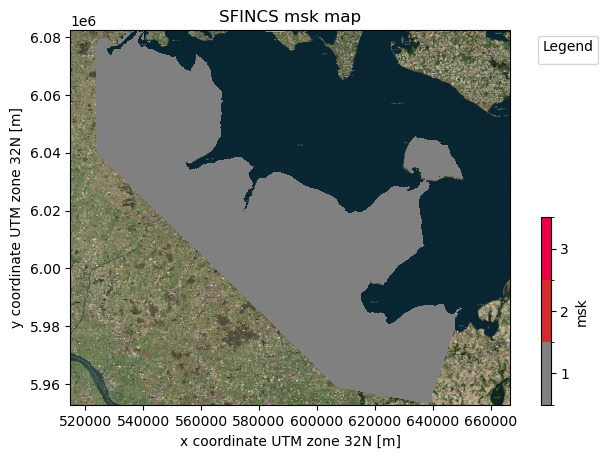

In [6]:
## Here we generate the mask of active (msk=1) and inactive cells (msk=0), determining what cells on your grid should be used. 
# For more info about the msk-file, click here: https://sfincs.readthedocs.io/en/latest/input.html#mask-file.
sf.setup_mask_active(zmin=-2, reset_mask=True)

# Make a plot of the mask file
_ = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)


In [7]:
## Defining outflow boundaries
# Loading a shapefile clicked by user:
gdf_include = sf.data_catalog.get_geodataframe('boundary_ocean')

<GeoAxes: title={'center': 'SFINCS msk map'}, xlabel='x coordinate UTM zone 32N [m]', ylabel='y coordinate UTM zone 32N [m]'>

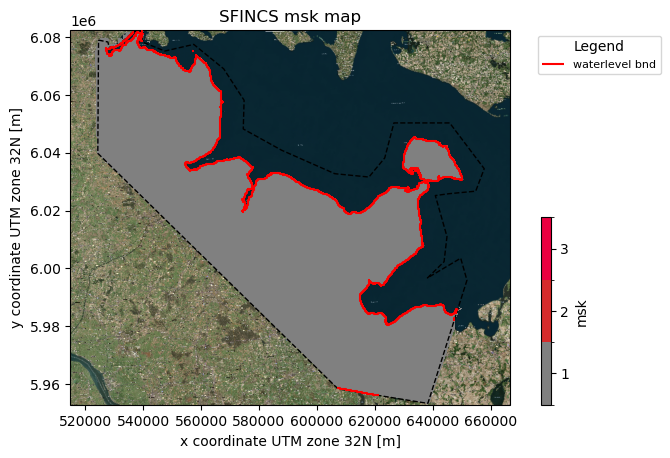

In [8]:
##Defining the boundary locations 

# Ocean: Here we addwaterlevel cells along the coastal boundary
sf.setup_mask_bounds(btype="waterlevel", include_mask=gdf_include, reset_bounds=True)

# Make a plot of the mask file with ocean boundary
fig, ax = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)
gdf_include.to_crs(sf.crs).boundary.plot(
    ax=ax, color="k", lw=1, ls="--"
)   #plot the shapefile given by the user as dashed line

In [9]:
####Setup roughness dataset ##########
#Add spatially varying roughness data
roughness = sf.data_catalog.get_rasterdataset("roughness")

datasets_rgh = [{"manning": roughness}]

#Setup roughness data into the model grid; if there are px that are not defined in the roughness dataset, the below values are asigned 
#the differentiation between sea and land is based on the elevation (rgh_lev_land) defined below

# If you use a subgrid (see below) this step is not required. 
sf.setup_manning_roughness(
   datasets_rgh = datasets_rgh,
   manning_land=0.04,
   manning_sea=0.02,
   rgh_lev_land=0,  # the minimum elevation of the land
)

#Plot the roughness map
_ = sf.plot_basemap(variable="manning", plot_bounds=False, bmap="sat", zoomlevel=12)


In [10]:
# Set period of model simulation time
sf.setup_config(
    **{
        "tref": "20230101 000000", 
        "tstart": "20230101 000000",
        "tstop": "20230106 201500",
    
    }
)



In [11]:
# Set up waterlevel forcing from tide gauges
## The datetime format in csv file has to be eg: 2018-05-08T18:40:00. The "time" column needs to be the index column
### The coordinates file has to start with the same index as the waterlevel timeseries file does. Otherwise no matching. 
sf.setup_waterlevel_forcing(
    locations='waterlevel_gauges',
    timeseries='waterlevel_timeseries',
    merge =True
)

sf.forcing.keys()

dict_keys(['bzs'])

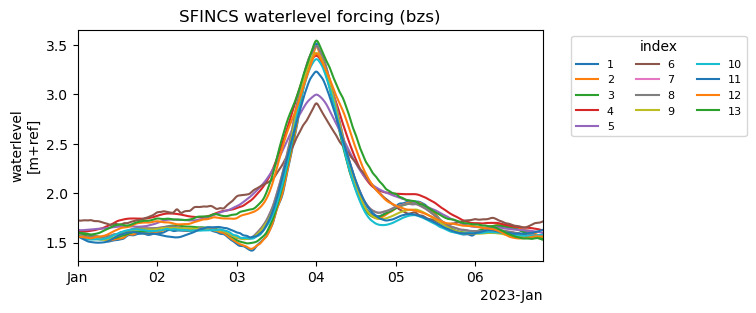

In [12]:
# Plot combined forcing time-series:
_ = sf.plot_forcing(fn_out='forcing.png')

In [13]:
#Add observation points
#NOTE:merge=True makes HydroMT merge the new observation points with already existing observation points (if present)
sf.setup_observation_points(
    locations=r"C:\Users\sungg1095\Documents\GitHub\baltic_sfincs\baltic_data\boundary\new_observation_points_1m.geojson", merge=True
)

# NOTE: the observation points are now stored in the sf.geoms dictionary
sf.geoms.keys()

dict_keys(['region', 'obs'])

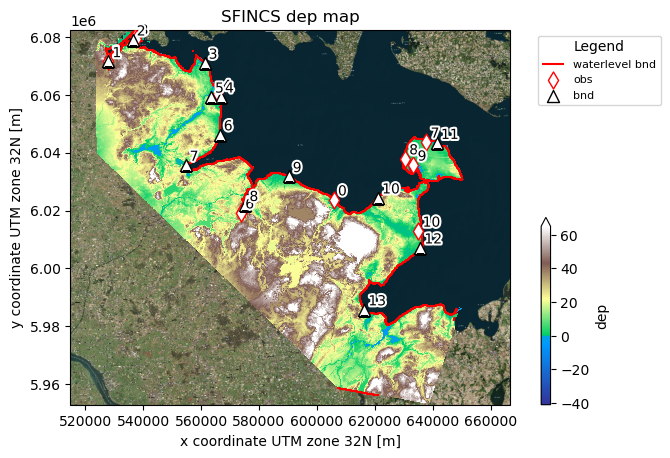

In [14]:
# Use predefined plotting function 'plot_basemap' to show your full SFINCS model setup
_ = sf.plot_basemap(fn_out="basemap.png" ,bmap="sat", zoomlevel=12)

In [15]:
# Write all model components to folder
sf.write()  # write all

# Show created files in folder:
dir_list = os.listdir(sf.root)
print(dir_list)


['boundary_plot.png', 'figs', 'gis', 'hydromt.log', 'mask_plot.png', 'run.bat', 'sfincs.bnd', 'sfincs.bzs', 'sfincs.dep', 'sfincs.ind', 'sfincs.inp', 'sfincs.man', 'sfincs.msk', 'sfincs.obs', 'sfincs_his.nc', 'sfincs_log.txt', 'sfincs_map.nc']


In [16]:
#Run the SFINCS Model
#find bat file and execute it
run_path = r"C:\Users\sungg1095\Documents\GitHub\baltic_sfincs\output"

cur_dir = os.getcwd()

os.chdir(run_path)
os.system("run.bat")
os.chdir(cur_dir)

In [17]:
#Show log file
fn = r"C:\Users\sungg1095\Documents\GitHub\baltic_sfincs\output\sfincs_log.txt"
with open(fn, "r") as f:
    txt = f.read()
print(txt)



 ----------- Welcome to SFINCS -----------

  @@@@@  @@@@@@@ @@ @@  @@   @@@@   @@@@@ 
 @@@ @@@ @@@@@@@ @@ @@@ @@ @@@@@@@ @@@ @@@
 @@@     @@      @@ @@@ @@ @@   @@ @@@    
  @@@@@  @@@@@@  @@ @@@@@@ @@       @@@@@ 
     @@@ @@      @@ @@ @@@ @@   @@     @@@
 @@@ @@@ @@      @@ @@  @@  @@@@@@ @@@ @@@
  @@@@@  @@      @@ @@   @   @@@@   @@@@@ 

              ..............              
          ......:@@@@@@@@:......          
       ..::::..@@........@@.:::::..       
     ..:::::..@@..::..::..@@.::::::..     
    .::::::..@@............@@.:::::::.    
   .::::::..@@..............@@.:::::::.   
  .::::::::..@@............@@..::::::::.  
 .:::::::::...@@.@..@@..@.@@..::::::::::. 
 .:::::::::...:@@@..@@..@@@:..:::::::::.. 
 ............@@.@@..@@..@@.@@............ 
 ^^^~~^^~~^^@@..............@@^^^~^^^~~^^ 
 .::::::::::@@..............@@.:::::::::. 
  .......:.@@.....@.....@....@@.:.......  
   .::....@@......@.@@@.@....@@.....::.   
    .:::~@@.:...:.@@...@@.:.:.@@~::::.    
     .::

In [18]:
# (Re-) Import modules

from os.path import join
import matplotlib.pyplot as plt
from hydromt_sfincs import SfincsModel, utils

sfincs_root = r"C:\Users\sungg1095\Documents\GitHub\baltic_sfincs\output"  # (relative) path to sfincs root
os.chdir(sfincs_root)
sfincs_root

'C:\\Users\\sungg1095\\Documents\\GitHub\\baltic_sfincs\\output'

In [19]:
#define a path to the directory "output"
path = "./output"
# show again all files in folder (bzw directory)
dir_list = os.listdir(sf.root)

# prints all files
##print(dir_list)

In [20]:
#Read Model results

mod = SfincsModel(sfincs_root, mode="r")

In [21]:
# we can simply read the model results (sfincs_map.nc) using the read_results method
## when observation points are earlier provided in the obsfile the output of sfincs_his.nc is displayed as well
sf.read_results()
# the following variables have been found
list(sf.results.keys())

['inp',
 'msk',
 'zb',
 'zs',
 'h',
 'zsmax',
 'hmax',
 'total_runtime',
 'average_dt',
 'point_zb',
 'point_zs',
 'point_h']

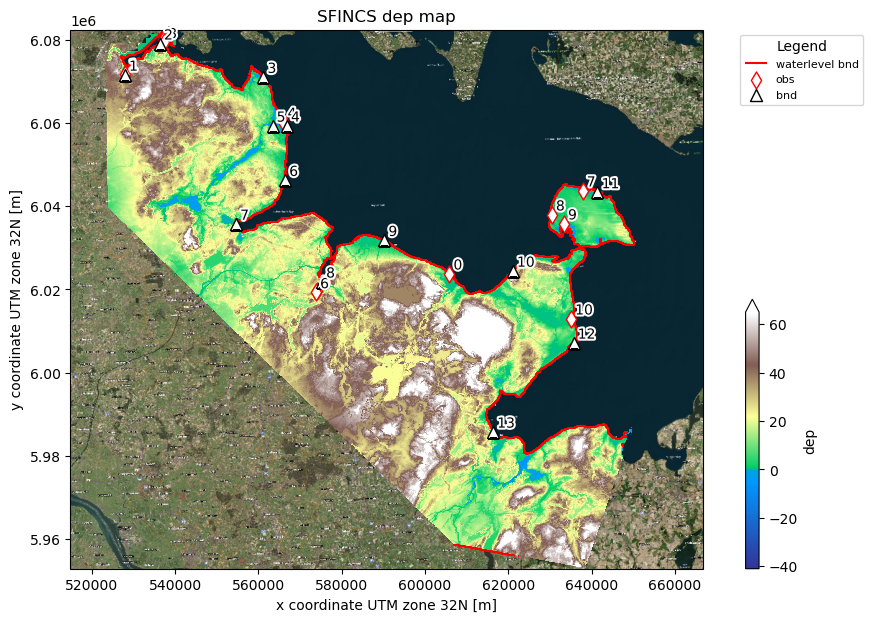

In [22]:
# plot the model layout
fig, ax = sf.plot_basemap(fn_out=None, bmap="sat", figsize=(11, 7))

In [23]:
# Write maximum waterdepth to geotiff file

sf.write_raster("results.hmax", compress="LZW", nodata= -9999)

Nodata value missing, skipping mask


Contents of sfincs_his.nc:
<xarray.Dataset>
Dimensions:        (stations: 11, time: 842, runtime: 1)
Coordinates:
    station_id     (stations) float32 ...
    station_name   (stations) |S256 ...
    point_x        (stations) float32 ...
    point_y        (stations) float32 ...
  * time           (time) datetime64[ns] 2023-01-01 ... 2023-01-06T20:10:00
Dimensions without coordinates: stations, runtime
Data variables:
    inp            int32 ...
    station_x      (stations) float32 ...
    station_y      (stations) float32 ...
    crs            int32 ...
    point_zb       (stations) float32 ...
    point_zs       (time, stations) float32 ...
    point_h        (time, stations) float32 ...
    total_runtime  (runtime) float32 ...
    average_dt     (runtime) float32 ...
Attributes:
    Conventions:                         Conventions = 'CF-1.6, SGRID-0.3
    Build-Revision-Date-Netcdf-library:  4.9.2 of Dec 10 2023 17:29:15 $
    Producer:                            SFINCS model: Su

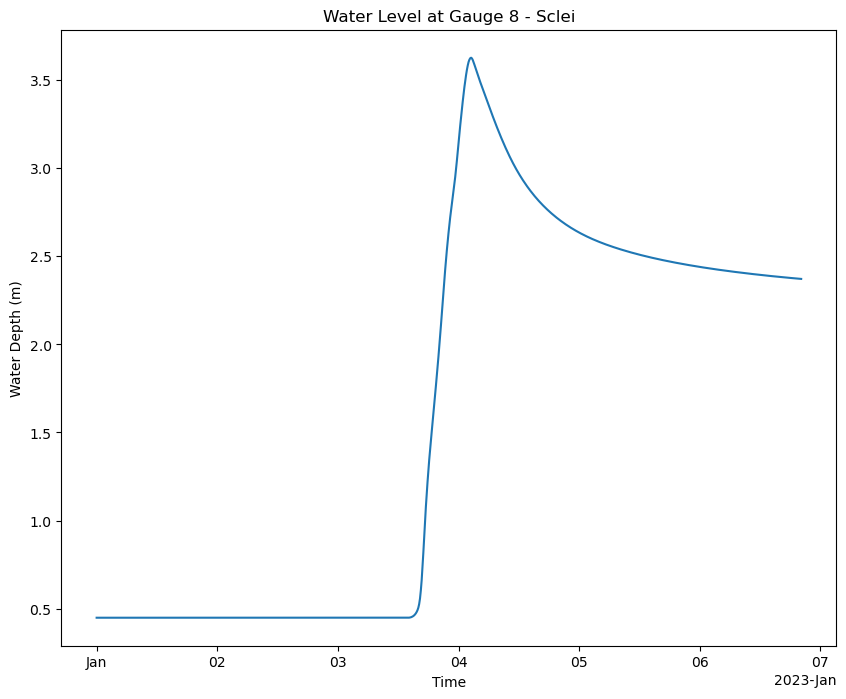

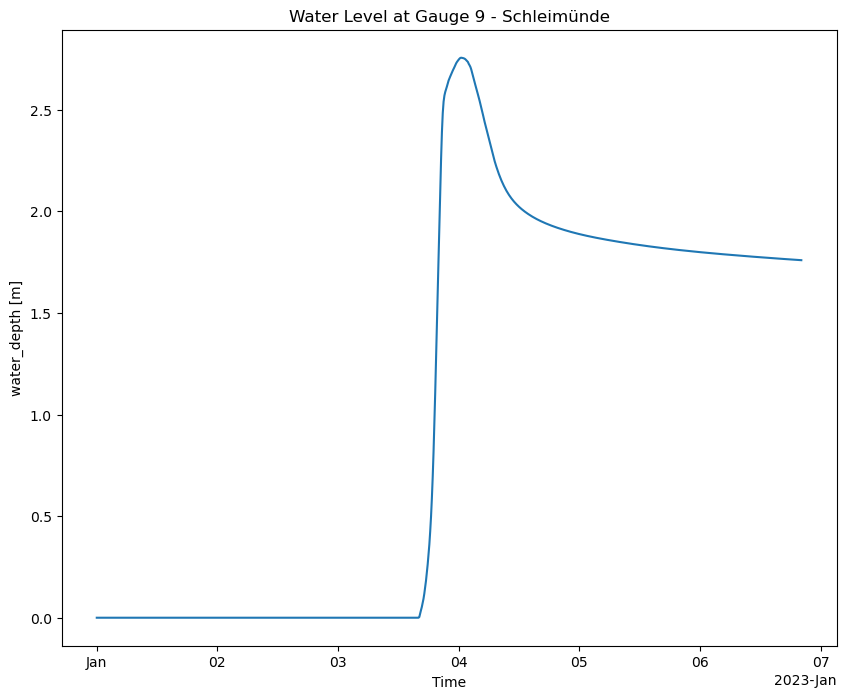

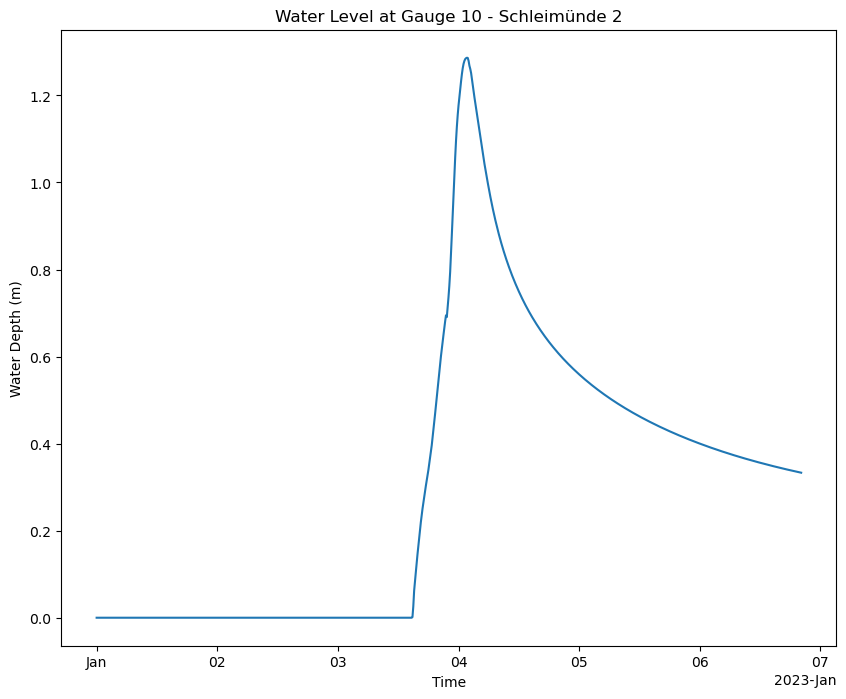

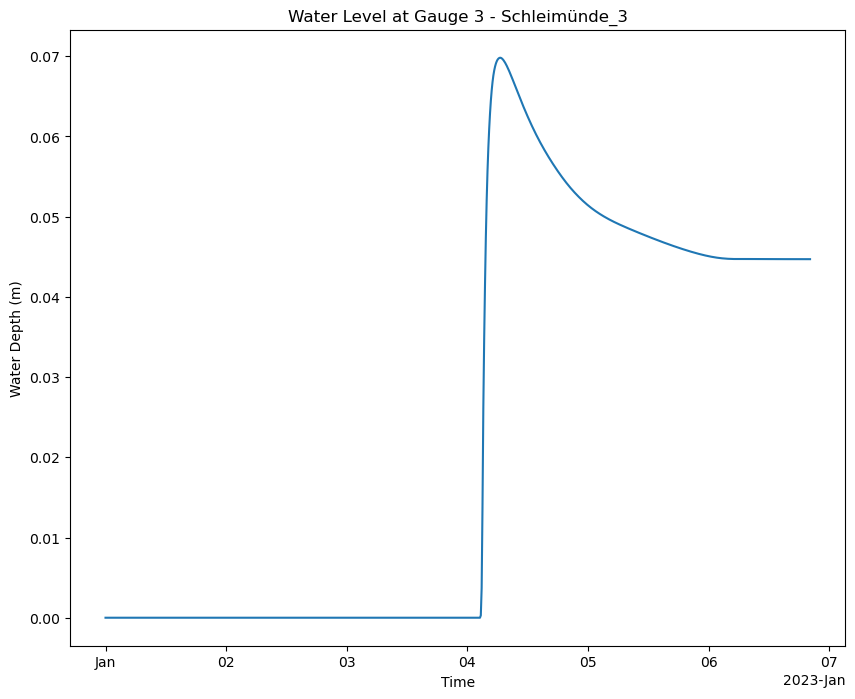

KeyError: "not all values found in index 'station_id'. Try setting the `method` keyword argument (example: method='nearest')."

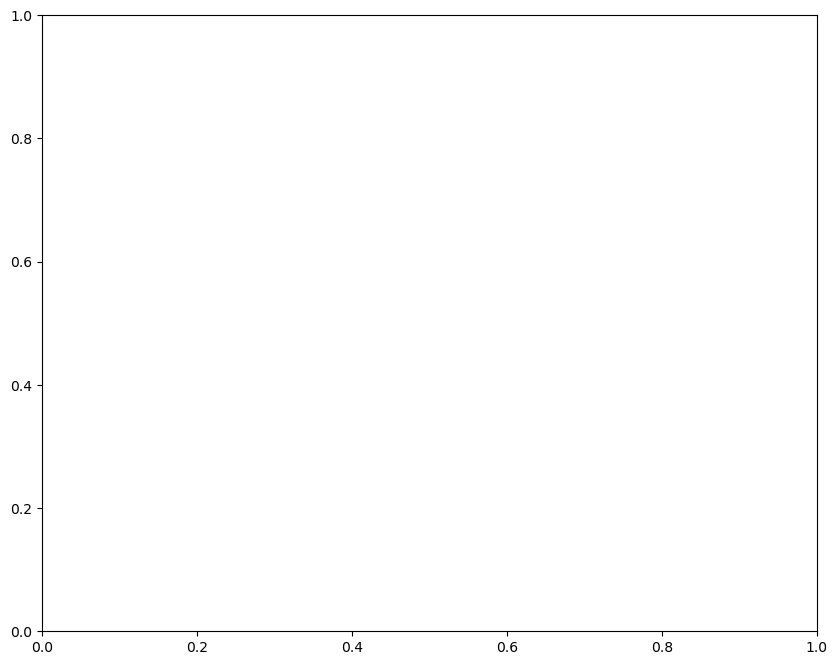

In [24]:
#Extracting the water depth data at specific gauge locations (observation points)

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mping

# Define the paths where the .obs file is stored
# map file is a specific file named "sfincs_his.nc" inside the sfincs_root directory
sfincs_root = os.path.abspath(r"C:\Users\sungg1095\Documents\GitHub\baltic_sfincs\output")
map_file = os.path.join(sfincs_root, 'sfincs_his.nc')

# Open the map file as a dataset using xarray and inspect its contents
map_ds = xr.open_dataset(map_file, engine='netcdf4')

print("Contents of sfincs_his.nc:")
print(map_ds)

# Extract the point_h variable (water depths at gauge locations)
if 'point_h' in map_ds:
    h_point = map_ds['point_h']
    print("point_h data array info:", h_point)
else:
    print("The 'point_h' variable is not found in the map dataset.")
    exit()

# Rename the dimension 'stations' to 'station_id'
h_point = h_point.rename({"stations": "station_id"})
h_point["station_id"] = h_point["station_id"].astype(int)

# Plot the water level at the eighth gauge
fig, ax = plt.subplots(figsize=(10, 8))
h_point.sel({"station_id": 8}).plot.line(x="time", ax=ax)
ax.set_title("Water Level at Gauge 8 - Schlei")
ax.set_xlabel("Time")
ax.set_ylabel("Water Depth (m)")
plt.show()

# Plot the water level at the nineth gauge
fig, ax = plt.subplots(figsize=(10, 8))
h_point.sel({"station_id": 9}).plot.line(x="time", ax=ax)
ax.set_title("Water Level at Gauge 9 - Schleimünde")
ax.set_xlabel("Time")
##ax.set_ylabel("Water Depth (m)")
##plt.show()

